<a href="https://colab.research.google.com/github/cdiegor/MineracaoDeDados/blob/main/Gestos_Rede_Neural_Functional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratório — Reconhecimento de Gestos com as Mãos (MediaPipe + Rede Neural, API Functional)

Este caderno implementa uma prática **interativa** e **em tempo real** usando **gestos** das mãos (MediaPipe) e uma **Rede Neural** construída com a **API Functional** do Keras.

**Fluxo:**

1. Coleta de dados com webcam (gestos definidos por você).  
2. Extração/normalização de **21×(x,y,z)** landmarks → vetor de **63 features**.  
3. Treinamento de uma RN com a API **Functional**.  
4. Inferência ao vivo.  
5. **Exercícios** no final para os alunos.

> **Requisitos locais** (instalar na sua máquina): `mediapipe`, `opencv-python`, `tensorflow` (ou `tensorflow-gpu`), `numpy`, `pandas`, `scikit-learn`, `matplotlib`.

In [ ]:
# (Opcional) Instalar pacotes — execute localmente se precisar
!pip install mediapipe opencv-python tensorflow pandas scikit-learn matplotlib

In [ ]:
import os, time, json, math
import numpy as np
import pandas as pd
import cv2, mediapipe as mp
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import io
import time
import base64
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow


print("OpenCV:", cv2.__version__)
print("MediaPipe:", mp.__version__)
print("TensorFlow:", tf.__version__)

OpenCV: 4.11.0
MediaPipe: 0.10.21
TensorFlow: 2.19.0


## 1) Parâmetros do projeto

In [ ]:
# ======= CONFIGURAÇÕES =======
ROTULOS = ["pedra", "papel", "tesoura"]  # edite aqui
AMOSTRAS_POR_ROTULO = 250                # frames a capturar por classe
PASTA_SAIDA = Path("gestos_dados")       # onde salvar CSVs e metadados
PASTA_SAIDA.mkdir(exist_ok=True)

# Nome do arquivo consolidado
ARQ_CSV = PASTA_SAIDA / "gestos_landmarks.csv"
ARQ_META = PASTA_SAIDA / "meta.json"

# Semente reprodutível
SEMENTE = 42
np.random.seed(SEMENTE)
tf.random.set_seed(SEMENTE)

# Exibir janela reduzida para melhorar desempenho
LARGURA_FRAME = 960
ALTURA_FRAME = 540

## 2) Extração & normalização de landmarks

- Usamos os **21** pontos do MediaPipe Hands por mão.  
- Normalização: centralizamos no punho (landmark 0) e escalamos pela **maior distância** entre pontos (`scale = max(||p_i - p_0||)`), para ficar invariante a escala.

In [ ]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_styles = mp.solutions.drawing_styles

def landmarks_para_vetor(landmarks):
    """Recebe uma lista de 21 landmarks (x,y,z em [0..1] relativos à imagem) e
    retorna um vetor 63-D normalizado: centralizado no punho e escalado pelo tamanho da mão."""
    pts = np.array([[lm.x, lm.y, lm.z] for lm in landmarks], dtype=np.float32)  # shape (21,3)
    origem = pts[0].copy()   # punho
    pts -= origem            # centraliza
    # escala pela maior distância ao punho (evita divisão por zero)
    dists = np.linalg.norm(pts, axis=1)
    scale = np.max(dists)
    if scale < 1e-6:
        scale = 1.0
    pts /= scale
    return pts.flatten()     # 63-D

def desenhar_mao(frame, results):
    if results.multi_hand_landmarks:
        for handLms in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                frame,
                handLms,
                mp_hands.HAND_CONNECTIONS,
                mp_styles.get_default_hand_landmarks_style(),
                mp_styles.get_default_hand_connections_style()
            )

## 3) Coleta de dados com webcam

### Como usar
1. Mostre o gesto da classe atual (indicada na janela).  
2. Pressione **`c`** para capturar um *lote* de frames (ex.: 10 por vez).  
3. Repita até atingir `AMOSTRAS_POR_ROTULO`.  
4. Pressione **`n`** para ir ao **próximo rótulo**.  
5. Pressione **`q`** para sair a qualquer momento (os dados coletados até então serão salvos).

In [ ]:
# 1. Configurações do JavaScript (Webcam no Browser)
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }
      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'Inicializando...';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = 640;
      video.height = 480;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia({video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML = '<br><span style="color: red; font-weight: bold;">CLIQUE NO VÍDEO PARA PARAR</span>';
      div.appendChild(instruction);

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640;
      captureCanvas.height = 480;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label_text) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }
      var preCreate = Date.now();
      stream = await createDom();

      if (labelElement) {
        labelElement.innerHTML = label_text;
      }
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }
      var p = new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      return p;
    }
    ''')
  display(js)

def js_to_image(js_reply):
  """Converte a imagem base64 do JS para OpenCV"""
  image_bytes = base64.b64decode(js_reply.split(',')[1])
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  img = cv2.imdecode(jpg_as_np, flags=1)
  return img

def landmarks_para_vetor(landmarks):
    """Achata x,y,z de cada ponto em uma lista simples"""
    lista = []
    # Agora 'landmarks' será a lista iterável correta
    for lm in landmarks:
        lista.extend([lm.x, lm.y, lm.z])
    return lista

# 2. Função de Coleta Principal
def coletar_dados_colab(rotulos, amostras_por_rotulo):
    video_stream()
    label_html = 'Inicializando...'

    mp_hands = mp.solutions.hands
    todos_registros = []
    meta_contagem = {r: 0 for r in rotulos}

    with mp_hands.Hands(
        static_image_mode=False,
        max_num_hands=1,
        min_detection_confidence=0.5
    ) as hands:

        for idx_rotulo, alvo in enumerate(rotulos):
            print(f"\n--- PREPARE-SE PARA O GESTO: {alvo} ---")
            print("Posicione a mão. A coleta começará em 3 segundos...")
            time.sleep(3)

            while meta_contagem[alvo] < amostras_por_rotulo:
                js_reply = eval_js(f'stream_frame("Coletando: {alvo} ({meta_contagem[alvo]}/{amostras_por_rotulo})")')
                if not js_reply:
                    print("Stream parado pelo usuário.")
                    return todos_registros

                frame = js_to_image(js_reply)
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame_rgb = cv2.flip(frame_rgb, 1)
                results = hands.process(frame_rgb)

                if results.multi_hand_landmarks:
                    for hand_landmarks in results.multi_hand_landmarks:
                        # CORREÇÃO AQUI: Usamos .landmark para pegar a lista de pontos
                        vec = landmarks_para_vetor(hand_landmarks.landmark)

                        todos_registros.append((vec, alvo))
                        meta_contagem[alvo] += 1

    print("Coleta finalizada!")
    return todos_registros

# --- CONFIGURAÇÃO E EXECUÇÃO ---
ROTULOS = ['Aberto', 'Fechado']
AMOSTRAS_POR_ROTULO = 50

dados = coletar_dados_colab(ROTULOS, AMOSTRAS_POR_ROTULO)

# Salvar CSV
if dados:
    X = np.vstack([r[0] for r in dados])
    y = np.array([r[1] for r in dados])
    df = pd.DataFrame(X)
    df['label'] = y
    df.to_csv(ARQ_CSV, index=False)
    print(f"Salvo dataset_gestos.csv com {len(df)} linhas.")
else:
    print("Nenhum dado coletado.")

<IPython.core.display.Javascript object>


--- PREPARE-SE PARA O GESTO: Aberto ---
Posicione a mão. A coleta começará em 3 segundos...

--- PREPARE-SE PARA O GESTO: Fechado ---
Posicione a mão. A coleta começará em 3 segundos...
Coleta finalizada!
Salvo dataset_gestos.csv com 100 linhas.


## 4) Carregar dados coletados e preparar treino
Se você já coletou e salvou o CSV (`gestos_dados/gestos_landmarks.csv`), rode a célula abaixo.

In [ ]:
assert ARQ_CSV.exists(), f"Arquivo não encontrado: {ARQ_CSV}. Colete dados com a célula anterior."
dados = pd.read_csv(ARQ_CSV)
print(dados.head())
print("Dimensões:", dados.shape)

# separar X e y
X = dados.drop(columns=["label"]).values.astype(np.float32)
labels = dados["label"].values

rotulos_unicos = sorted(np.unique(labels).tolist())
rotulo2id = {r:i for i,r in enumerate(rotulos_unicos)}
y = np.array([rotulo2id[r] for r in labels], dtype=np.int64)

print("Rótulos:", rotulos_unicos)
print("Distribuição:", pd.Series(labels).value_counts().to_dict())

          0         1             2         3         4         5         6  \
0  0.946732  0.600384  5.162692e-07  0.844764  0.582539 -0.044881  0.755694   
1  0.883060  0.479918  6.775433e-07  0.776043  0.382487 -0.030223  0.701869   
2  0.897252  0.396865  3.959964e-07  0.793984  0.366610 -0.043226  0.710718   
3  0.903695  0.392869  4.036623e-07  0.834517  0.441912 -0.070892  0.773896   
4  0.766040  0.942915  7.202541e-07  0.662736  0.889885 -0.051100  0.590900   

          7         8         9  ...        54        55        56        57  \
0  0.477344 -0.063750  0.703546  ...  1.037717  0.228479 -0.098734  1.063905   
1  0.250155 -0.039040  0.654889  ...  0.982981  0.034354 -0.029423  0.988954   
2  0.233629 -0.055470  0.666824  ...  0.979494 -0.005096 -0.025431  0.983383   
3  0.431146 -0.117970  0.716971  ...  1.065065  0.248431 -0.115712  1.076796   
4  0.771571 -0.081621  0.543393  ...  0.929020  0.562795 -0.163803  0.955752   

         58        59        60        61   

In [ ]:
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEMENTE
)

scaler = StandardScaler().fit(X_tr)
X_tr = scaler.transform(X_tr)
X_te = scaler.transform(X_te)

X_tr.shape, X_te.shape

((80, 63), (20, 63))

## 5) Rede Neural (API Functional)

Arquitetura simples com **camadas densas** (MLP), **Dropout** e **softmax** final.

In [ ]:
n_classes = len(rotulos_unicos)

entrada = Input(shape=(X_tr.shape[1],), name="entrada_63d")
C1 = Dense(128, activation="relu", name="densa_128")(entrada)
C2 = Dropout(0.25, name="drop_25")(C1)
C3 = Dense(64, activation="relu", name="densa_64")(C2)
C4 = Dropout(0.15, name="drop_15")(C3)
saida = Dense(n_classes, activation="softmax", name="saida_softmax")(C4)

modelo = Model(inputs=entrada, outputs=saida, name="gestos_mlp_functional")
modelo.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
modelo.summary()

Model: "gestos_mlp_functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ entrada_63d (InputLayer)        │ (None, 63)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densa_128 (Dense)               │ (None, 128)            │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_25 (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densa_64 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_15 (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ saida_softmax (Dense)           │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,578 (64.76 KB)

 Trainable params: 16,578 (64.76 KB)

 Non-trainable params: 0 (0.00 B)

## 6) Treino, relatório e matriz de confusão

Epoch 1/80
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4844 - loss: 1.0609 - val_accuracy: 0.6250 - val_loss: 0.5447 - learning_rate: 0.0010
Epoch 2/80
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.4844 - loss: 0.8887 - val_accuracy: 0.8750 - val_loss: 0.3977 - learning_rate: 0.0010
Epoch 3/80
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.5312 - loss: 0.7617 - val_accuracy: 0.9375 - val_loss: 0.3114 - learning_rate: 0.0010
Epoch 4/80
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.5469 - loss: 0.6444 - val_accuracy: 1.0000 - val_loss: 0.2612 - learning_rate: 0.0010
Epoch 5/80
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.7656 - loss: 0.5165 - val_accuracy: 1.0000 - val_loss: 0.2282 - learning_rate: 0.0010
Epoch 6/80
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.7969 - loss: 0.4664 - val_accuracy: 0.9375 - val_loss: 0.2080 - learning_rate: 0.0010
Epoch 7/80
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9062 - loss: 0.3712 - val_accuracy: 0.9

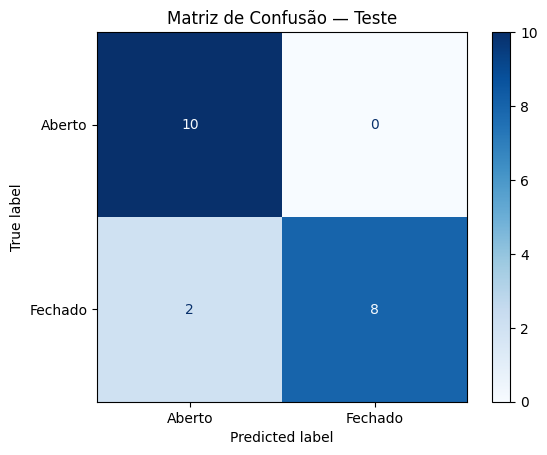

In [ ]:
callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5),
    ModelCheckpoint(filepath=str(PASTA_SAIDA / "melhor_modelo.keras"),
                    monitor="val_accuracy", save_best_only=True)
]

hist = modelo.fit(
    X_tr, y_tr,
    epochs=80,
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

# Avaliação em teste
te_loss, te_acc = modelo.evaluate(X_te, y_te, verbose=0)
print(f"Acurácia (teste): {te_acc:.4f}")
y_pred = np.argmax(modelo.predict(X_te), axis=1)
print(classification_report(y_te, y_pred, target_names=rotulos_unicos))

cm = confusion_matrix(y_te, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=rotulos_unicos)
disp.plot(cmap="Blues", values_format="d")
plt.title("Matriz de Confusão — Teste")
plt.show()

## 7) Inferência ao vivo (webcam)

Mostre um gesto para a câmera; o modelo predirá em tempo real.  
**Teclas:** `q` sai.

In [ ]:
import json

def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var overlayCanvas; // Novo: para desenhar linhas
    var ctx;           // Contexto do desenho
    var imgElement;
    var labelElement;
    var pendingResolve = null;
    var shutdown = false;

    // Conexões da mão (MediaPipe) para desenhar as linhas
    const HAND_CONNECTIONS = [
      [0,1],[1,2],[2,3],[3,4],         // Polegar
      [0,5],[5,6],[6,7],[7,8],         // Indicador
      [5,9],[9,10],[10,11],[11,12],    // Médio
      [9,13],[13,14],[14,15],[15,16],  // Anelar
      [13,17],[17,18],[18,19],[19,20], // Mínimo
      [0,17]                           // Palma
    ];

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       overlayCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }
      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      div.style.position = 'relative'; // Importante para o overlay
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'Inicializando...';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = 640;
      video.height = 480;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia({video: { facingMode: "environment"}});
      div.appendChild(video);

      // Criação do Canvas de Overlay (Transparente)
      overlayCanvas = document.createElement('canvas');
      overlayCanvas.width = 640;
      overlayCanvas.height = 480;
      overlayCanvas.style.position = 'absolute';
      overlayCanvas.style.top = video.offsetTop + 'px';
      overlayCanvas.style.left = video.offsetLeft + 'px';
      overlayCanvas.style.zIndex = 10;
      overlayCanvas.style.pointerEvents = 'none'; // Cliques passam para o vídeo
      div.appendChild(overlayCanvas);
      ctx = overlayCanvas.getContext('2d');

      const instruction = document.createElement('div');
      instruction.innerHTML = '<br><span style="color: red; font-weight: bold;">CLIQUE NO VÍDEO PARA PARAR</span>';
      div.appendChild(instruction);

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640;
      captureCanvas.height = 480;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }

    async function stream_frame(label_text, landmarks_json) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }
      var preCreate = Date.now();
      stream = await createDom();

      if (labelElement) {
        labelElement.innerHTML = label_text;
      }

      // --- LÓGICA DE DESENHO NO BROWSER ---
      if (ctx && landmarks_json) {
        ctx.clearRect(0, 0, 640, 480); // Limpa desenho anterior
        var landmarks = JSON.parse(landmarks_json);

        if (landmarks && landmarks.length > 0) {
           // Desenhar Linhas (Esqueleto)
           ctx.lineWidth = 2;
           ctx.strokeStyle = "#00FF00"; // Verde
           for (let j = 0; j < HAND_CONNECTIONS.length; j++) {
              let idx1 = HAND_CONNECTIONS[j][0];
              let idx2 = HAND_CONNECTIONS[j][1];
              let p1 = landmarks[idx1];
              let p2 = landmarks[idx2];
              // As coordenadas vêm normalizadas (0 a 1), multiplicar pelo tamanho
              ctx.beginPath();
              ctx.moveTo(p1.x * 640, p1.y * 480);
              ctx.lineTo(p2.x * 640, p2.y * 480);
              ctx.stroke();
           }

           // Desenhar Pontos Vermelhos
           ctx.fillStyle = "#FF0000";
           for (let i = 0; i < landmarks.length; i++) {
             let x = landmarks[i].x * 640;
             let y = landmarks[i].y * 480;
             ctx.beginPath();
             ctx.arc(x, y, 4, 0, 2 * Math.PI);
             ctx.fill();
           }
        }
      } else if (ctx) {
         ctx.clearRect(0, 0, 640, 480); // Limpa se não tiver mão
      }
      // ------------------------------------

      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }
      var p = new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      return p;
    }
    ''')
  display(js)

In [ ]:
def inferencia_visual_colab(modelo, scaler, rotulos, conf_min=0.5):
    video_stream()

    mp_hands = mp.solutions.hands
    pred_txt = "Aguardando gesto..."
    landmarks_json = "[]" # Inicialmente vazio

    with mp_hands.Hands(
        static_image_mode=False,
        max_num_hands=1,
        min_detection_confidence=0.6,
        min_tracking_confidence=0.6
    ) as hands:

        while True:
            # Enviamos texto E os dados dos pontos (JSON) para o JS desenhar
            js_reply = eval_js(f'stream_frame("{pred_txt}", \'{landmarks_json}\')')

            if not js_reply:
                print("Inferência encerrada.")
                break

            frame = js_to_image(js_reply)

            # Processamento MediaPipe
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            #frame_rgb = cv2.flip(frame_rgb, 1)
            results = hands.process(frame_rgb)

            landmarks_json = "[]" # Reseta para o próximo frame

            if results.multi_hand_landmarks:
                # 1. Pega os landmarks
                lm_list = results.multi_hand_landmarks[0].landmark

                #lm_data = [{'x': 1 - lm.x, 'y': lm.y} for lm in lm_list]

                # 2. Prepara os dados para desenhar no JS (Lista de dicts x, y)
                # Nota: Não espelhamos x aqui porque o vídeo no HTML já é espelhado se a camera for frontal,
                # mas se o desenho sair invertido, altere x para (1 - lm.x)
                lm_data = [{'x': lm.x, 'y': lm.y} for lm in lm_list]
                landmarks_json = json.dumps(lm_data)

                # 3. Prepara vetor para o modelo (Feature Vector)
                vec = landmarks_para_vetor(lm_list)
                vec_np = np.array(vec).reshape(1, -1)

                if scaler:
                    vec_np = scaler.transform(vec_np)

                # 4. Predição
                proba = modelo.predict(vec_np, verbose=0)[0]
                k = int(np.argmax(proba))
                conf = float(proba[k])

                if conf >= conf_min:
                    cor = "green"
                    pred_txt = f"<span style='color:{cor}'>Pred: {rotulos[k]} ({conf*100:.1f}%)</span>"
                else:
                    pred_txt = f"<span style='color:orange'>Indefinido ({conf*100:.1f}%)</span>"
            else:
                pred_txt = "<span style='color:gray'>Nenhuma mão detectada</span>"

    print("Fim.")

In [ ]:
# --- EXECUÇÃO ---
print("Iniciando inferência com visualização de esqueleto...")
inferencia_visual_colab(modelo, scaler, rotulos_unicos, conf_min=0.5)

Iniciando inferência com visualização de esqueleto...


<IPython.core.display.Javascript object>

Inferência encerrada.
Fim.


---
## 8) Exercícios propostos

1. **Novo gesto**: adicione um rótulo (ex.: `joinha`) e **recolete** dados. Atualize `ROTULOS` e refaça o treino.  
2. **Robustez**: varie iluminação, distância e posição. Meça queda de acurácia e discuta estratégias (mais dados, *augmentation* geométrica nos landmarks, regularização).  
3. **Arquitetura**: modifique a rede (camadas, neurônios, *dropout*). Compare no conjunto de teste.  
4. **Threshold**: ajuste `conf_min` na inferência para reduzir falsos positivos. Plote acurácia vs. threshold.  
5. **Cross-user**: colete dados de 2–3 pessoas e avalie generalização com *GroupKFold* (agrupando por pessoa).  
6. **Feature engineering**: além de `(x,y,z)` normalizados, acrescente **distâncias** ou **ângulos** entre pontos (ex.: distância entre ponta do indicador e polegar). Veja se melhora.  
7. **Latência**: meça FPS com e sem desenhar landmarks (use `time.time()`), relate impacto no desempenho.  
8. **Multi-mão** (avançado): habilite `max_num_hands=2` e crie rótulos que dependem de duas mãos simultâneas (ex.: “duplo joinha”).  
9. **Salvar/Carregar**: salve `melhor_modelo.keras` e o `StandardScaler` (pickle) e crie um script só de inferência.  
10. **Comparação**: treine um **SVM** (sklearn) com as mesmas features e compare com a RN (accuracy e matriz de confusão).